## Turbine hub height optimization

Another type of design variable that can be specified is the turbines' hub heights. In this case, the hub heights are converted into continuous variables so a gradient-based optimization with [autograd](https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/Optimization.html#Autograd) can be performed. This approach is taken to speed up the optimization process.

In this example, it is necessary to specify a "[GenericWindTurbine](https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/WindTurbines.html)" since the hub heights need to change throughout the optimization and thus the power and thrust coefficient curve will change for each hub height studied.


**Install TOPFARM if needed**

In [ ]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

We now import the site, turbine positions and wake models necessary to run the optimization. The Lillgrund site will be used and its layout extracted from PyWake's data.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from py_wake.examples.data.lillgrund import LillgrundSite, power_curve, ct_curve
from py_wake.wind_turbines._wind_turbines import WindTurbines, WindTurbine
from py_wake.wind_turbines.generic_wind_turbines import GenericWindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

from topfarm.easy_drivers import EasyScipyOptimizeDriver
from py_wake.deficit_models.gaussian import BastankhahGaussian

from topfarm.cost_models.cost_model_wrappers import AEPCostModelComponent

from py_wake.utils.gradients import autograd

from topfarm import TopFarmProblem

/Users/julianquick/miniconda3/envs/sgd/lib/python3.10/site-packages/openmdao/utils/general_utils.py:128: OMDeprecationWarning:simple_warning is deprecated. Use openmdao.utils.om_warnings.issue_warning instead.
/Users/julianquick/miniconda3/envs/sgd/lib/python3.10/site-packages/openmdao/utils/notebook_utils.py:157: UserWarning:Tabulate is not installed. Run `pip install openmdao[notebooks]` to install required dependencies. Using ASCII for outputs.


Now we specify the initial conditions and hub height boundaries. The turbines' hub heights are staggered and assigned to every couple wind turbine in the farm.

In [ ]:
# Initial inputs
n_wt = 7

n_wd = 1
wd = [270]

lb = 82                         # lower boundary constraint
ub = 160                        # upper boundary constraint

hh = 80                         # starting hub height condition
hg = 120                        # second starting hub height condition
h = np.ones([n_wt]) * hh          # hub height array
h_max = np.ones([n_wt]) * ub      # baseline hub height

for i in range(n_wt):
    if i % 2 == 0:
        h[i] = hh
    else:
        h[i] = hg

print('wind farm hub heights:',h)

power = 2300
diameter = np.ones([n_wt]) * 93 # diameter [m]

# Site specification
site = LillgrundSite()

x = np.linspace(0, 93 * 4 * n_wt, n_wt)

y = [0] * n_wt

wind farm hub heights: [ 80. 120.  80. 120.  80. 120.  80.]


Then we need to set up the `GenericWindTurbine` object and the `WindFarmModel`.

In [ ]:
nom_power_array = power * np.ones([n_wt]) # rated power array

class SWT23(WindTurbine):   # Siemens 2.3 MW
    def __init__(self, method='linear'):
        """
        Parameters
        ----------
        method : {'linear', 'pchip'}
            linear(fast) or pchip(smooth and gradient friendly) interpolation
        """
        WindTurbine.__init__(self, name='SWT23', diameter=93, hub_height=80,
                             powerCtFunction=PowerCtTabular(power_curve[:, 0], power_curve[:, 1], 'kw',
                                                            ct_curve[:, 1], method=method))

wind_turbines = WindTurbines(
                names=['SWT23' for i in range(len(x))],
                diameters = diameter,
                hub_heights = h,
                powerCtFunctions=[GenericWindTurbine(name='SWT23',
                                                        diameter = diameter[i], 
                                                        hub_height = h[i], 
                                                        power_norm = nom_power_array[i]).powerCtFunction for i in range(len(x))])

wf_model = BastankhahGaussian(site, wind_turbines)

Lastly, we set up the `CostModelComponent` that is responsible for calculating the AEP and works as the objective function in the optimization.

In [ ]:
# AEP Calculation

class PyWakeAEPCostModelComponent(AEPCostModelComponent):
    def __init__(self, windFarmModel, n_wt, wd=None, ws=None, max_eval=None, grad_method=autograd, n_cpu=1, **kwargs):
        self.windFarmModel = windFarmModel

        #objective function
        def get_aep_func(h):

            h_new = h[:n_wt]
            simres = windFarmModel(x, y, h=h_new)
            aep = simres.aep().sum()

            return aep

        #specifying the gradients
        def daep_h(h):
            return windFarmModel.aep_gradients(autograd, wrt_arg=['h'])(x, y, h)
        
        AEPCostModelComponent.__init__(self,
                                       input_keys=['h'],
                                       n_wt=n_wt,
                                       cost_function=get_aep_func,
                                       cost_gradient_function=daep_h,
                                       output_unit='GWh',
                                       max_eval=max_eval, **kwargs)

cost_comp = PyWakeAEPCostModelComponent(windFarmModel=wf_model, n_wt=len(x), grad_method=autograd, n_cpu=1, wd=None, ws=None)

Lastly, we set up the `TopFarmProblem` along with some optimization parameters.

In [ ]:
# optimization specs and problem formulation

maxiter = 20
tol = 1e-6

problem = TopFarmProblem(design_vars= {'h':(h, lb, ub)},
                        cost_comp=cost_comp,
                        driver=EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=maxiter, tol=tol),
                        n_wt=n_wt,
                        expected_cost=0.001
                        )

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


In [ ]:
_,state,_=problem.optimize()

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Optimization terminated successfully    (Exit mode 0)
            Current function value: -62622.45189217626
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
Optimization Complete
-----------------------------------


Now we plot the turbines in the XZ plane to visualize the final hub heights.

final hub heights: [ 82. 160.  82. 160.  82. 160.  82.]


Text(0.5, 0, 'x [m]')

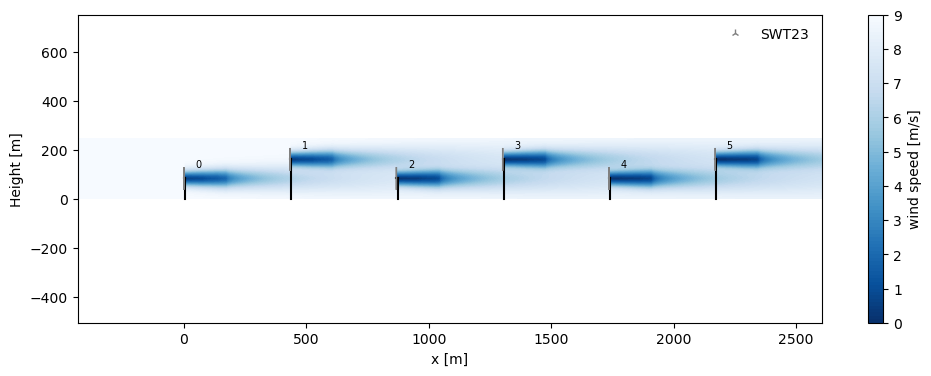

In [ ]:
from py_wake import XZGrid
h = np.around(state['h'])
print('final hub heights:',h)

#taking only the first row of turbines
x = x[:6]
y = y[:6]
h = h[:6]

sim_res_ref = wf_model(x, y, wd=[270])
sim_res_opt = wf_model(x, y, h=h, wd=[270])
plt.figure(figsize=(12,4))
sim_res_opt.flow_map(XZGrid(y=0)).plot_wake_map()
plt.ylabel('Height [m]')
plt.xlabel('x [m]')